In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from typing import Tuple, List, Set

# Configuração para gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Ambiente Não Determinista

In [2]:
class StochasticGridEnvironment:
    """Ambiente de grelha 10x10 com transições estocásticas."""
    
    def __init__(self, stochastic_prob: float = 0.05, use_walls: bool = True):
        """
        Args:
            stochastic_prob: Probabilidade de transição aleatória (default: 5%)
            use_walls: Se True, usa paredes do Exercício 4
        """
        self.grid_size = 10
        self.n_states = 100
        self.goal_state = 100
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        self.n_actions = len(self.actions)
        
        # Probabilidade de comportamento estocástico
        self.stochastic_prob = stochastic_prob
        
        # Paredes (opcional)
        self.use_walls = use_walls
        if use_walls:
            self.walls = {4, 14, 24, 34, 44, 54, 64, 74, 84, 
                         17, 27, 37, 47, 57, 67, 77, 87, 97}
        else:
            self.walls = set()
        
        # Recompensas
        self.wall_penalty = -0.1
        self.goal_reward = 100.0
        
        # Estatísticas
        self.stochastic_transitions = 0
        self.total_transitions = 0
        
    def state_to_position(self, state: int) -> Tuple[int, int]:
        """Converte estado (1-100) para posição (linha, coluna)."""
        row = (state - 1) // self.grid_size
        col = (state - 1) % self.grid_size
        return row, col
    
    def position_to_state(self, row: int, col: int) -> int:
        """Converte posição (linha, coluna) para estado (1-100)."""
        return row * self.grid_size + col + 1
    
    def get_neighbors(self, state: int) -> List[int]:
        """Retorna todos os estados vizinhos válidos."""
        row, col = self.state_to_position(state)
        neighbors = []
        
        # Verifica todos os 4 vizinhos
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            new_row, new_col = row + dr, col + dc
            
            # Verifica se está dentro da grelha
            if 0 <= new_row < self.grid_size and 0 <= new_col < self.grid_size:
                new_state = self.position_to_state(new_row, new_col)
                # Adiciona se não for parede
                if new_state not in self.walls:
                    neighbors.append(new_state)
        
        return neighbors
    
    def deterministic_transition(self, state: int, action: str) -> Tuple[int, float]:
        """Executa transição determinista (mesma lógica do exercício anterior)."""
        row, col = self.state_to_position(state)
        
        # Calcula novo estado baseado na ação
        if action == 'UP':
            new_row, new_col = row - 1, col
        elif action == 'DOWN':
            new_row, new_col = row + 1, col
        elif action == 'LEFT':
            new_row, new_col = row, col - 1
        elif action == 'RIGHT':
            new_row, new_col = row, col + 1
        else:
            raise ValueError(f"Ação inválida: {action}")
        
        # Verifica se novo estado é válido
        if (new_row < 0 or new_row >= self.grid_size or 
            new_col < 0 or new_col >= self.grid_size):
            return state, self.wall_penalty
        
        new_state = self.position_to_state(new_row, new_col)
        
        # Verifica se novo estado é parede
        if new_state in self.walls:
            return state, self.wall_penalty
        
        # Movimento válido
        reward = self.goal_reward if new_state == self.goal_state else 0.0
        return new_state, reward
    
    def stochastic_transition(self, state: int) -> Tuple[int, float]:
        """Executa transição estocástica para estado vizinho aleatório."""
        neighbors = self.get_neighbors(state)
        
        if not neighbors:
            # Sem vizinhos válidos, permanece no mesmo estado
            return state, 0.0
        
        # Escolhe vizinho aleatório
        new_state = np.random.choice(neighbors)
        reward = self.goal_reward if new_state == self.goal_state else 0.0
        
        return new_state, reward
    
    def transition(self, state: int, action: str) -> Tuple[int, float]:
        """Executa transição com possibilidade de comportamento estocástico."""
        self.total_transitions += 1
        
        # Com probabilidade stochastic_prob, faz transição aleatória
        if np.random.random() < self.stochastic_prob:
            self.stochastic_transitions += 1
            return self.stochastic_transition(state)
        else:
            # Comportamento determinista normal
            return self.deterministic_transition(state, action)
    
    def get_reward(self, state: int) -> float:
        """Retorna recompensa do estado."""
        return self.goal_reward if state == self.goal_state else 0.0
    
    def random_action(self) -> str:
        """Retorna ação aleatória."""
        return np.random.choice(self.actions)
    
    def reset_statistics(self):
        """Reset das estatísticas de transições."""
        self.stochastic_transitions = 0
        self.total_transitions = 0
    
    def get_stochastic_ratio(self) -> float:
        """Retorna proporção de transições estocásticas."""
        if self.total_transitions == 0:
            return 0.0
        return self.stochastic_transitions / self.total_transitions
    
    def visualize_environment(self, title: str = "Ambiente Não Determinista"):
        """Visualiza o ambiente."""
        grid = np.zeros((self.grid_size, self.grid_size))
        
        # Marca paredes
        for wall in self.walls:
            row, col = self.state_to_position(wall)
            grid[row, col] = -1
        
        # Marca objetivo
        goal_row, goal_col = self.state_to_position(self.goal_state)
        grid[goal_row, goal_col] = 2
        
        plt.figure(figsize=(10, 10))
        plt.imshow(grid, cmap='RdYlGn', interpolation='nearest')
        plt.colorbar(label='Tipo de célula', ticks=[-1, 0, 2])
        plt.gca().set_yticklabels([])
        plt.gca().set_xticklabels([])
        
        # Adiciona números dos estados
        for state in range(1, self.n_states + 1):
            row, col = self.state_to_position(state)
            color = 'white' if state in self.walls else 'black'
            plt.text(col, row, str(state), ha='center', va='center', 
                    fontsize=8, color=color, weight='bold')
        
        title_text = f"{title}\nProbabilidade de transição aleatória: {self.stochastic_prob*100:.1f}%"
        if self.use_walls:
            title_text += "\n-1: Parede, 0: Livre, 2: Objetivo"
        
        plt.title(title_text, fontsize=12, weight='bold')
        plt.tight_layout()
        plt.show()

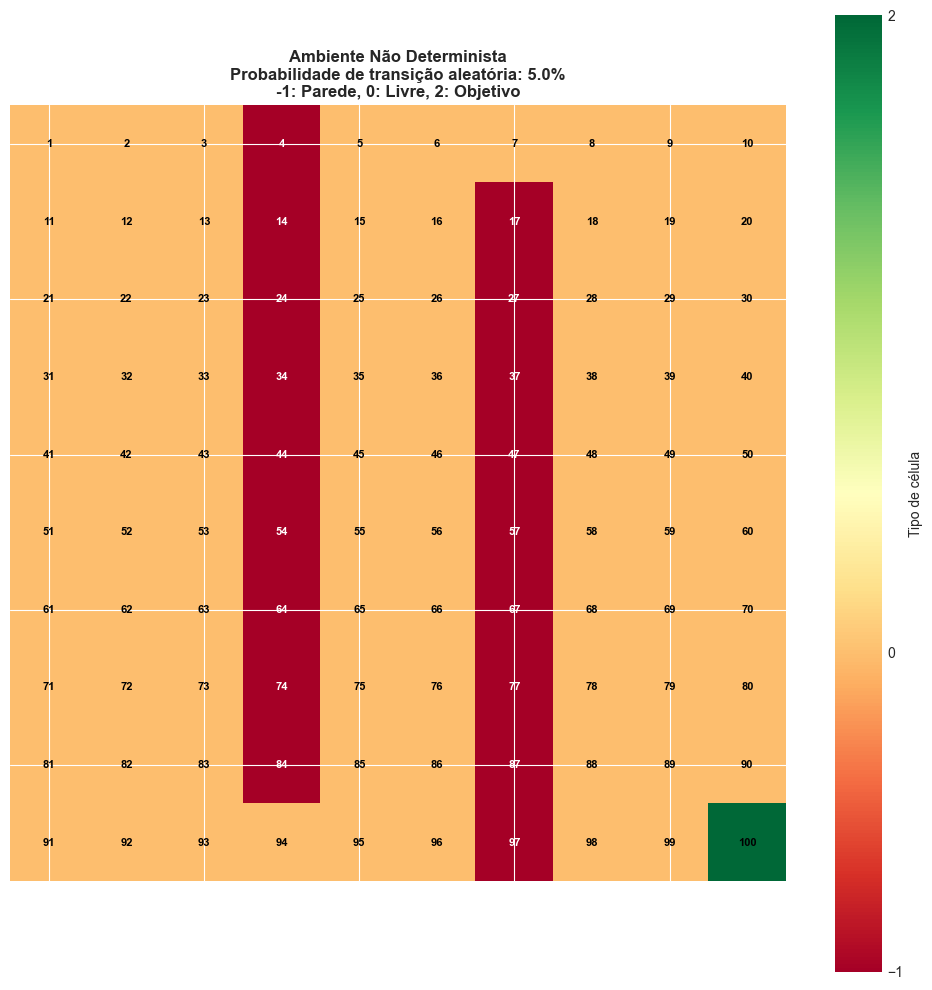

In [3]:
# Visualizar ambiente não determinista
env_stochastic = StochasticGridEnvironment(stochastic_prob=0.05, use_walls=True)
env_stochastic.visualize_environment()

## 2. Q-Learning para Ambiente Estocástico

In [4]:
class StochasticQLearningAgent:
    """Agente Q-Learning para ambiente estocástico."""
    
    def __init__(self, env: StochasticGridEnvironment, alpha: float = 0.7, gamma: float = 0.99):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        
        # Tabela Q: [estado, ação]
        self.Q = np.zeros((env.n_states + 1, env.n_actions))
        
        # Contadores para análise
        self.state_visits = np.zeros(env.n_states + 1)
        self.action_counts = np.zeros((env.n_states + 1, env.n_actions))
        
    def get_action_index(self, action: str) -> int:
        """Converte ação para índice."""
        return self.env.actions.index(action)
    
    def get_best_action(self, state: int) -> str:
        """Retorna melhor ação para o estado (com desempate aleatório)."""
        q_values = self.Q[state]
        max_q = np.max(q_values)
        best_actions = [i for i, q in enumerate(q_values) if q == max_q]
        best_action_idx = np.random.choice(best_actions)
        return self.env.actions[best_action_idx]
    
    def update_q(self, state: int, action: str, reward: float, next_state: int):
        """Atualiza valor Q."""
        action_idx = self.get_action_index(action)
        current_q = self.Q[state, action_idx]
        max_next_q = np.max(self.Q[next_state])
        
        # Q-learning update
        new_q = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * max_next_q)
        self.Q[state, action_idx] = new_q
        
        # Atualiza contadores
        self.state_visits[state] += 1
        self.action_counts[state, action_idx] += 1
    
    def train_epsilon_greedy(self, n_steps: int, test_points: List[int], 
                            greed: float = 0.9, initial_state: int = 1) -> dict:
        """Treino com estratégia ε-greedy."""
        results = {
            'test_points': test_points,
            'test_rewards': [],
            'test_steps': [],
            'q_stability': []  # Mede variação na tabela Q
        }
        
        state = initial_state
        test_idx = 0
        prev_Q = self.Q.copy()
        
        for step in range(1, n_steps + 1):
            # Escolhe ação: greedy ou aleatória
            if np.random.random() < greed:
                action = self.get_best_action(state)
            else:
                action = self.env.random_action()
            
            next_state, reward = self.env.transition(state, action)
            
            # Atualiza Q
            self.update_q(state, action, reward, next_state)
            
            # Reset se chegou ao objetivo
            if next_state == self.env.goal_state:
                state = initial_state
            else:
                state = next_state
            
            # Teste nos pontos especificados
            if test_idx < len(test_points) and step == test_points[test_idx]:
                test_reward, test_step = self.test_policy(n_steps=1000, initial_state=initial_state)
                results['test_rewards'].append(test_reward)
                results['test_steps'].append(test_step)
                
                # Calcula estabilidade da tabela Q
                q_change = np.mean(np.abs(self.Q - prev_Q))
                results['q_stability'].append(q_change)
                prev_Q = self.Q.copy()
                
                test_idx += 1
        
        return results
    
    def test_policy(self, n_steps: int = 1000, initial_state: int = 1) -> Tuple[float, int]:
        """Testa política atual sem atualizar Q.
        
        Retorna:
            - recompensa média por passo
            - número de passos até objetivo (ou n_steps se não atingir)
        """
        state = initial_state
        total_reward = 0.0
        steps = 0
        
        for _ in range(n_steps):
            action = self.get_best_action(state)
            next_state, reward = self.env.transition(state, action)
            
            total_reward += reward
            steps += 1
            
            if next_state == self.env.goal_state:
                break
            
            state = next_state
        
        avg_reward = total_reward / steps if steps > 0 else 0.0
        return avg_reward, steps
    
    def get_utility_map(self) -> np.ndarray:
        """Retorna mapa de utilidade máxima por estado."""
        utility = np.zeros((self.env.grid_size, self.env.grid_size))
        
        for state in range(1, self.env.n_states + 1):
            row, col = self.env.state_to_position(state)
            if state in self.env.walls:
                utility[row, col] = np.nan
            else:
                utility[row, col] = np.max(self.Q[state])
        
        return utility
    
    def get_policy_stability(self, other_agent: 'StochasticQLearningAgent') -> float:
        """Mede diferença entre duas políticas."""
        differences = 0
        total_states = 0
        
        for state in range(1, self.env.n_states + 1):
            if state not in self.env.walls:
                action1 = self.get_best_action(state)
                action2 = other_agent.get_best_action(state)
                if action1 != action2:
                    differences += 1
                total_states += 1
        
        return differences / total_states if total_states > 0 else 0.0
    
    def visualize_utility(self, title: str = "Mapa de Utilidade"):
        """Visualiza mapa de utilidade."""
        utility = self.get_utility_map()
        
        plt.figure(figsize=(12, 10))
        im = plt.imshow(utility, cmap='viridis', interpolation='nearest')
        plt.colorbar(im, label='Utilidade Máxima')
        
        # Adiciona valores
        for state in range(1, self.env.n_states + 1):
            row, col = self.env.state_to_position(state)
            if state not in self.env.walls:
                max_q = np.max(self.Q[state])
                plt.text(col, row, f'{max_q:.1f}', ha='center', va='center',
                        fontsize=8, color='white' if max_q > np.nanmean(utility) else 'black')
        
        plt.title(title, fontsize=14, weight='bold')
        plt.tight_layout()
        plt.show()

## 3. Experimentos Comparativos

Vamos comparar o desempenho em três cenários:
1. **Determinista** (0% aleatoriedade)
2. **Ligeiramente estocástico** (5% aleatoriedade)
3. **Muito estocástico** (15% aleatoriedade)

In [5]:
# Parâmetros
n_experiments = 30
n_training_steps = 20000
test_points = [100, 200, 500, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
greed = 0.9

# Diferentes níveis de estocasticidade
stochastic_levels = [0.0, 0.05, 0.15]
level_names = ['Determinista (0%)', 'Ligeiramente Estocástico (5%)', 'Muito Estocástico (15%)']

# Armazenar resultados
all_results = {}

for stoch_prob, level_name in zip(stochastic_levels, level_names):
    print(f"\n{'='*80}")
    print(f"Testando ambiente: {level_name}")
    print(f"{'='*80}")
    
    results = {
        'test_rewards': np.zeros((n_experiments, len(test_points))),
        'test_steps': np.zeros((n_experiments, len(test_points))),
        'q_stability': np.zeros((n_experiments, len(test_points))),
        'execution_times': [],
        'stochastic_ratios': [],
        'agents': []  # Guarda último agente de cada experimento
    }
    
    for exp in range(n_experiments):
        np.random.seed(exp)
        
        # Cria ambiente e agente
        env = StochasticGridEnvironment(stochastic_prob=stoch_prob, use_walls=True)
        agent = StochasticQLearningAgent(env)
        
        env.reset_statistics()
        start_time = time.time()
        
        # Treino
        exp_results = agent.train_epsilon_greedy(n_training_steps, test_points, greed=greed)
        
        exec_time = time.time() - start_time
        
        # Armazena resultados
        results['test_rewards'][exp] = exp_results['test_rewards']
        results['test_steps'][exp] = exp_results['test_steps']
        results['q_stability'][exp] = exp_results['q_stability']
        results['execution_times'].append(exec_time)
        results['stochastic_ratios'].append(env.get_stochastic_ratio())
        results['agents'].append(agent)
        
        if (exp + 1) % 5 == 0:
            print(f"Experimento {exp + 1}/{n_experiments} concluído (tempo: {exec_time:.2f}s, " 
                  f"transições estocásticas: {env.get_stochastic_ratio()*100:.2f}%)")
    
    all_results[level_name] = results
    
    # Estatísticas
    print(f"\n{'-'*80}")
    print(f"ESTATÍSTICAS - {level_name}")
    print(f"{'-'*80}")
    print(f"Tempo médio de execução: {np.mean(results['execution_times']):.2f} ± {np.std(results['execution_times']):.2f} s")
    print(f"Recompensa final (20000 passos): {np.mean(results['test_rewards'][:, -1]):.4f} ± {np.std(results['test_rewards'][:, -1]):.4f}")
    print(f"Passos finais até objetivo: {np.mean(results['test_steps'][:, -1]):.2f} ± {np.std(results['test_steps'][:, -1]):.2f}")
    print(f"Proporção real de transições estocásticas: {np.mean(results['stochastic_ratios'])*100:.2f}% ± {np.std(results['stochastic_ratios'])*100:.2f}%")
    print(f"Mudança média em Q (estabilidade): {np.mean(results['q_stability'][:, -1]):.4f} ± {np.std(results['q_stability'][:, -1]):.4f}")

print("\n" + "="*80)
print("TODOS OS EXPERIMENTOS CONCLUÍDOS")
print("="*80)


Testando ambiente: Determinista (0%)
Experimento 5/30 concluído (tempo: 0.23s, transições estocásticas: 0.00%)
Experimento 5/30 concluído (tempo: 0.23s, transições estocásticas: 0.00%)
Experimento 10/30 concluído (tempo: 0.21s, transições estocásticas: 0.00%)
Experimento 10/30 concluído (tempo: 0.21s, transições estocásticas: 0.00%)
Experimento 15/30 concluído (tempo: 0.20s, transições estocásticas: 0.00%)
Experimento 15/30 concluído (tempo: 0.20s, transições estocásticas: 0.00%)
Experimento 20/30 concluído (tempo: 0.22s, transições estocásticas: 0.00%)
Experimento 20/30 concluído (tempo: 0.22s, transições estocásticas: 0.00%)
Experimento 25/30 concluído (tempo: 0.21s, transições estocásticas: 0.00%)
Experimento 25/30 concluído (tempo: 0.21s, transições estocásticas: 0.00%)
Experimento 30/30 concluído (tempo: 0.21s, transições estocásticas: 0.00%)

--------------------------------------------------------------------------------
ESTATÍSTICAS - Determinista (0%)
------------------------

## 4. Análise de Convergência

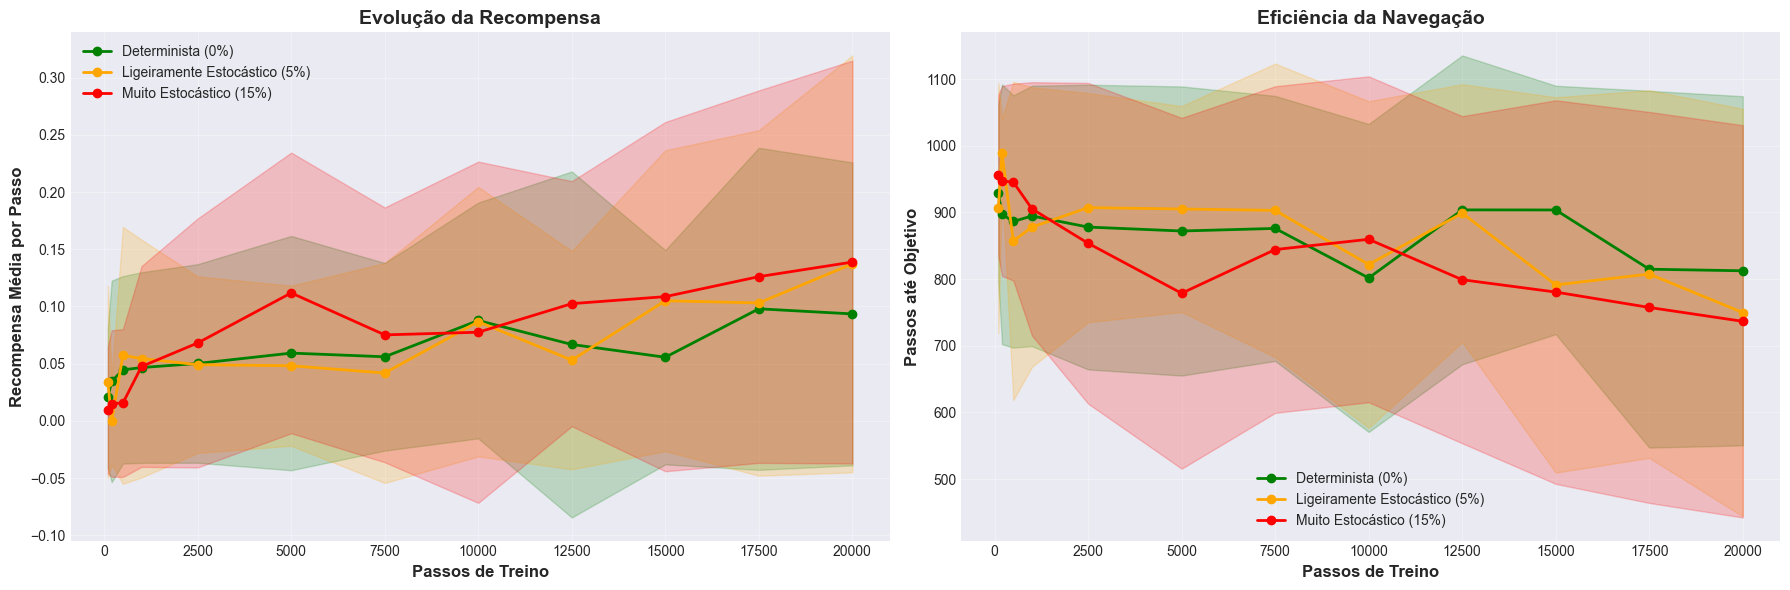

In [6]:
# Gráfico 1: Evolução da Recompensa
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

colors = ['green', 'orange', 'red']

# Recompensa média
for i, (level_name, color) in enumerate(zip(level_names, colors)):
    results = all_results[level_name]
    mean_rewards = np.mean(results['test_rewards'], axis=0)
    std_rewards = np.std(results['test_rewards'], axis=0)
    
    axes[0].plot(test_points, mean_rewards, 'o-', linewidth=2, markersize=6, 
                 label=level_name, color=color)
    axes[0].fill_between(test_points, mean_rewards - std_rewards, 
                          mean_rewards + std_rewards, alpha=0.2, color=color)

axes[0].set_xlabel('Passos de Treino', fontsize=12, weight='bold')
axes[0].set_ylabel('Recompensa Média por Passo', fontsize=12, weight='bold')
axes[0].set_title('Evolução da Recompensa', fontsize=14, weight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Número de passos até objetivo
for i, (level_name, color) in enumerate(zip(level_names, colors)):
    results = all_results[level_name]
    mean_steps = np.mean(results['test_steps'], axis=0)
    std_steps = np.std(results['test_steps'], axis=0)
    
    axes[1].plot(test_points, mean_steps, 'o-', linewidth=2, markersize=6, 
                 label=level_name, color=color)
    axes[1].fill_between(test_points, mean_steps - std_steps, 
                          mean_steps + std_steps, alpha=0.2, color=color)

axes[1].set_xlabel('Passos de Treino', fontsize=12, weight='bold')
axes[1].set_ylabel('Passos até Objetivo', fontsize=12, weight='bold')
axes[1].set_title('Eficiência da Navegação', fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

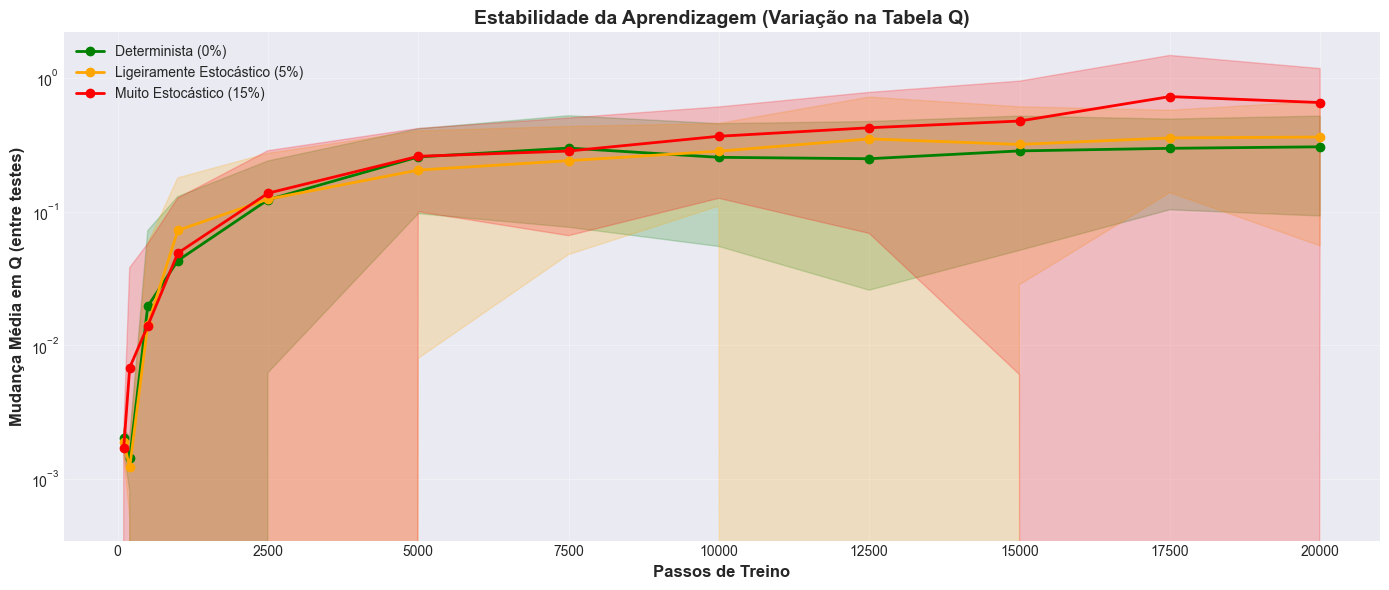

In [7]:
# Gráfico 2: Estabilidade da Tabela Q
plt.figure(figsize=(14, 6))

for level_name, color in zip(level_names, colors):
    results = all_results[level_name]
    mean_stability = np.mean(results['q_stability'], axis=0)
    std_stability = np.std(results['q_stability'], axis=0)
    
    plt.plot(test_points, mean_stability, 'o-', linewidth=2, markersize=6, 
             label=level_name, color=color)
    plt.fill_between(test_points, mean_stability - std_stability, 
                     mean_stability + std_stability, alpha=0.2, color=color)

plt.xlabel('Passos de Treino', fontsize=12, weight='bold')
plt.ylabel('Mudança Média em Q (entre testes)', fontsize=12, weight='bold')
plt.title('Estabilidade da Aprendizagem (Variação na Tabela Q)', fontsize=14, weight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.yscale('log')  # Escala logarítmica para melhor visualização
plt.tight_layout()
plt.show()

## 5. Análise de Estabilidade da Política

C:\Users\alexa\AppData\Local\Temp\ipykernel_13240\309819892.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([policy_differences[name] for name in level_names],


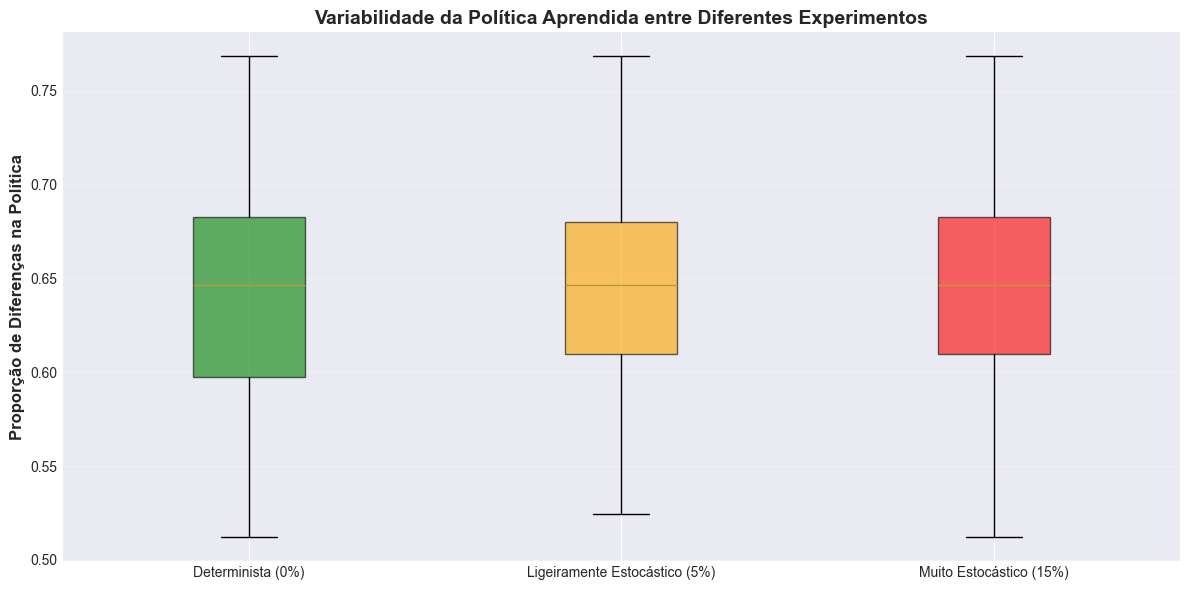


ESTATÍSTICAS DE VARIABILIDADE DA POLÍTICA
Determinista (0%):
  Diferença média: 64.02% ± 5.59%
  Diferença máxima: 76.83%
  Diferença mínima: 51.22%

Ligeiramente Estocástico (5%):
  Diferença média: 64.49% ± 4.92%
  Diferença máxima: 76.83%
  Diferença mínima: 52.44%

Muito Estocástico (15%):
  Diferença média: 64.63% ± 5.43%
  Diferença máxima: 76.83%
  Diferença mínima: 51.22%



In [8]:
# Mede diferença entre políticas de diferentes experimentos
policy_differences = {}

for level_name in level_names:
    results = all_results[level_name]
    agents = results['agents']
    
    # Compara políticas entre pares de experimentos
    differences = []
    for i in range(len(agents)):
        for j in range(i + 1, min(i + 5, len(agents))):  # Compara com próximos 5
            diff = agents[i].get_policy_stability(agents[j])
            differences.append(diff)
    
    policy_differences[level_name] = differences

# Visualização
plt.figure(figsize=(12, 6))
positions = [1, 2, 3]
bp = plt.boxplot([policy_differences[name] for name in level_names], 
                  positions=positions, labels=level_names, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.ylabel('Proporção de Diferenças na Política', fontsize=12, weight='bold')
plt.title('Variabilidade da Política Aprendida entre Diferentes Experimentos', 
          fontsize=14, weight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Estatísticas
print("\nESTATÍSTICAS DE VARIABILIDADE DA POLÍTICA")
print("="*80)
for level_name in level_names:
    diffs = policy_differences[level_name]
    print(f"{level_name}:")
    print(f"  Diferença média: {np.mean(diffs)*100:.2f}% ± {np.std(diffs)*100:.2f}%")
    print(f"  Diferença máxima: {np.max(diffs)*100:.2f}%")
    print(f"  Diferença mínima: {np.min(diffs)*100:.2f}%")
    print()

## 6. Comparação Visual dos Mapas de Utilidade

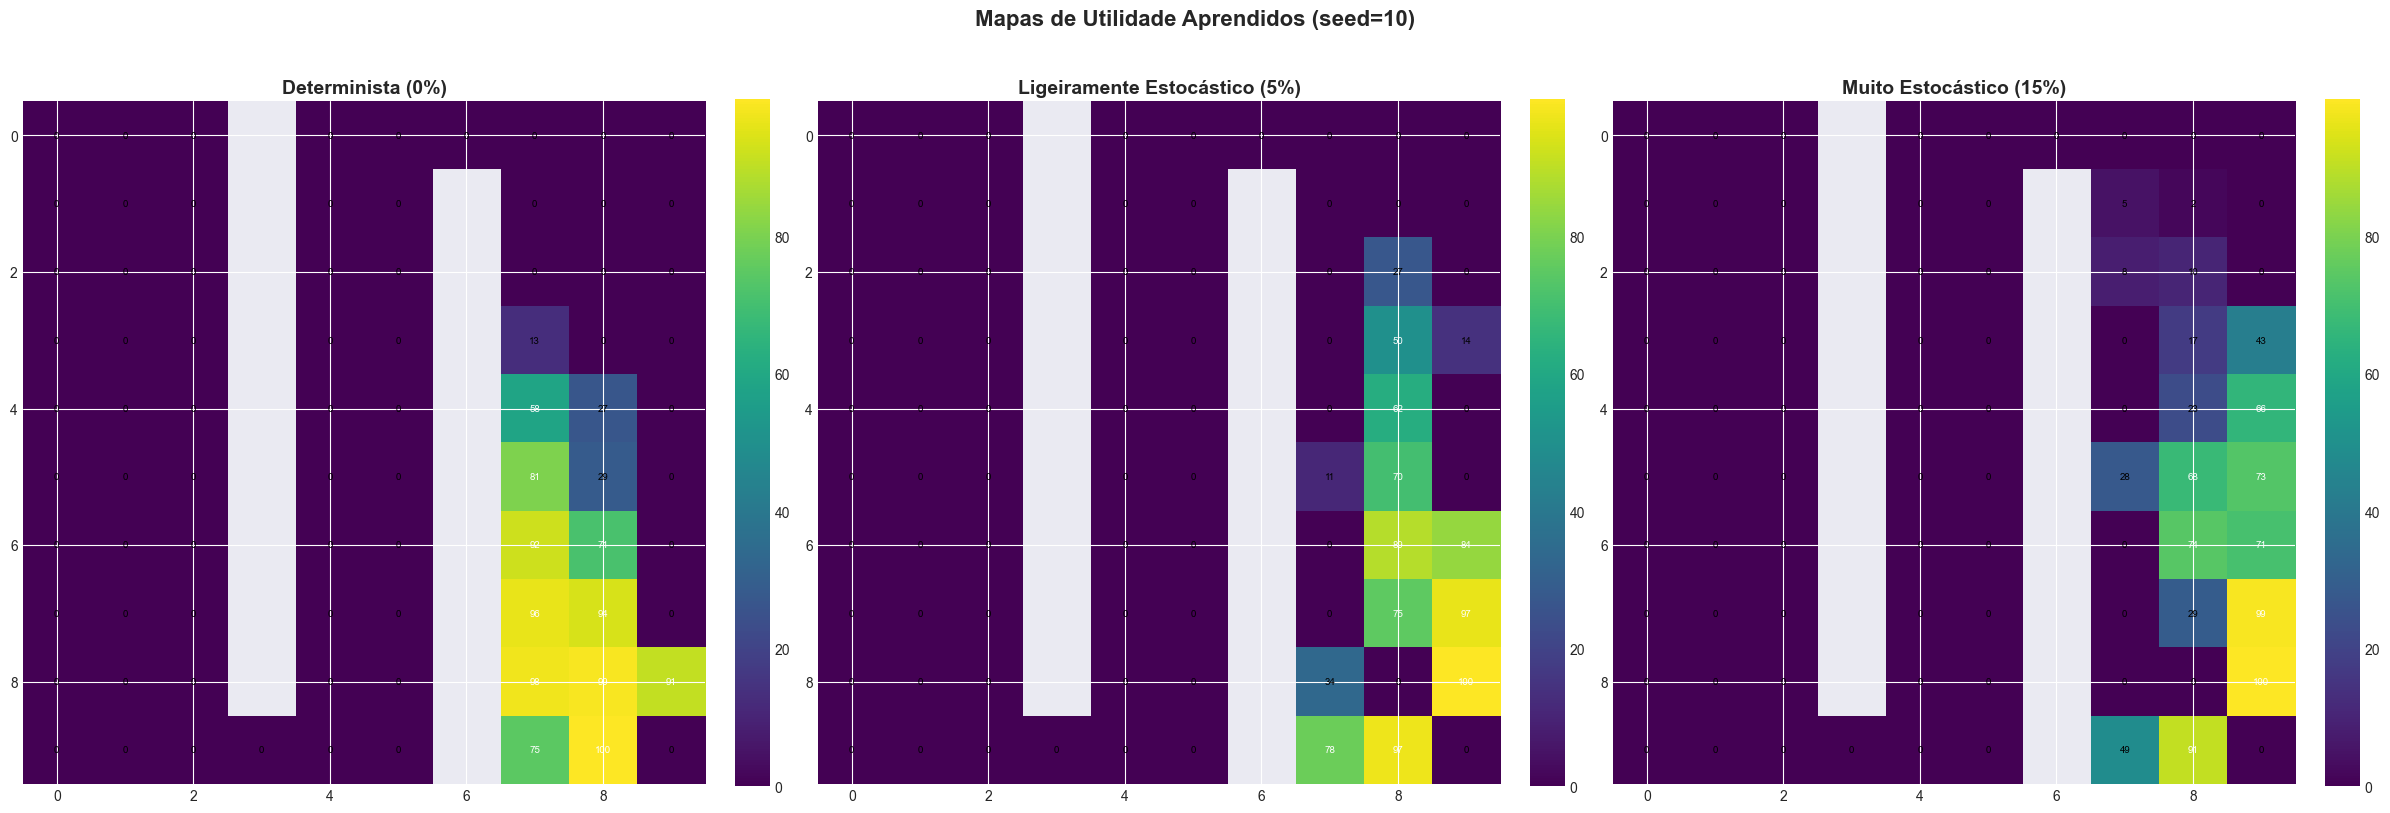

In [9]:
# Visualizar mapas de utilidade para cada nível de estocasticidade
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for idx, level_name in enumerate(level_names):
    # Usa agente do experimento com seed=10
    agent = all_results[level_name]['agents'][10]
    utility = agent.get_utility_map()
    
    im = axes[idx].imshow(utility, cmap='viridis', interpolation='nearest')
    axes[idx].set_title(level_name, fontsize=14, weight='bold')
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    
    # Adiciona valores
    for state in range(1, agent.env.n_states + 1):
        row, col = agent.env.state_to_position(state)
        if state not in agent.env.walls:
            max_q = np.max(agent.Q[state])
            if not np.isnan(max_q):
                axes[idx].text(col, row, f'{max_q:.0f}', ha='center', va='center',
                              fontsize=7, color='white' if max_q > 50 else 'black')

plt.suptitle('Mapas de Utilidade Aprendidos (seed=10)', fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 7. Análise de Desempenho em Teste

In [10]:
# Teste mais extensivo: múltiplas execuções da política aprendida
n_test_runs = 50
test_performance = {}

for level_name in level_names:
    print(f"\nTestando políticas aprendidas: {level_name}")
    
    results = all_results[level_name]
    agents = results['agents']
    
    all_test_rewards = []
    all_test_steps = []
    
    # Para cada agente treinado
    for agent in agents[:10]:  # Usa primeiros 10 agentes
        # Testa múltiplas vezes
        for _ in range(n_test_runs // 10):
            test_reward, test_steps = agent.test_policy(n_steps=1000)
            all_test_rewards.append(test_reward)
            all_test_steps.append(test_steps)
    
    test_performance[level_name] = {
        'rewards': all_test_rewards,
        'steps': all_test_steps
    }
    
    print(f"  Recompensa média: {np.mean(all_test_rewards):.4f} ± {np.std(all_test_rewards):.4f}")
    print(f"  Passos médios: {np.mean(all_test_steps):.2f} ± {np.std(all_test_steps):.2f}")


Testando políticas aprendidas: Determinista (0%)
  Recompensa média: 0.0691 ± 0.1389
  Passos médios: 875.44 ± 225.90

Testando políticas aprendidas: Ligeiramente Estocástico (5%)
  Recompensa média: 0.0691 ± 0.1389
  Passos médios: 875.44 ± 225.90

Testando políticas aprendidas: Ligeiramente Estocástico (5%)
  Recompensa média: 0.0914 ± 0.1899
  Passos médios: 855.08 ± 255.31

Testando políticas aprendidas: Muito Estocástico (15%)
  Recompensa média: 0.0914 ± 0.1899
  Passos médios: 855.08 ± 255.31

Testando políticas aprendidas: Muito Estocástico (15%)
  Recompensa média: 0.1769 ± 0.2538
  Passos médios: 727.92 ± 317.72
  Recompensa média: 0.1769 ± 0.2538
  Passos médios: 727.92 ± 317.72


C:\Users\alexa\AppData\Local\Temp\ipykernel_13240\2298267131.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot(rewards_data, labels=level_names, patch_artist=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_13240\2298267131.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(steps_data, labels=level_names, patch_artist=True)


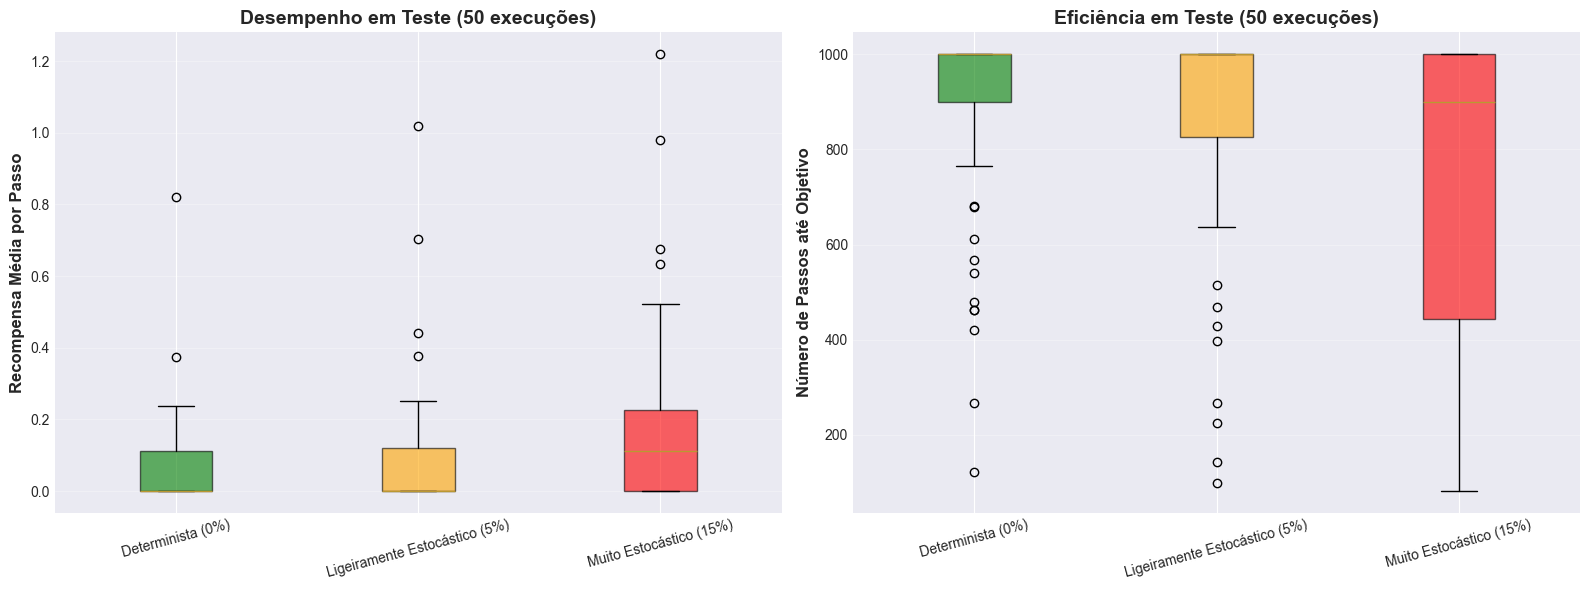

In [11]:
# Visualização dos testes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Recompensas
rewards_data = [test_performance[name]['rewards'] for name in level_names]
bp1 = axes[0].boxplot(rewards_data, labels=level_names, patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[0].set_ylabel('Recompensa Média por Passo', fontsize=12, weight='bold')
axes[0].set_title('Desempenho em Teste (50 execuções)', fontsize=14, weight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=15)

# Passos
steps_data = [test_performance[name]['steps'] for name in level_names]
bp2 = axes[1].boxplot(steps_data, labels=level_names, patch_artist=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[1].set_ylabel('Número de Passos até Objetivo', fontsize=12, weight='bold')
axes[1].set_title('Eficiência em Teste (50 execuções)', fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

## 8. Análise Estatística Comparativa

In [12]:
# Tabela comparativa final
print("\n" + "="*100)
print("RESUMO COMPARATIVO - IMPACTO DA ESTOCASTICIDADE")
print("="*100)
print(f"{'Métrica':<40} | {'Determinista':<15} | {'5% Aleatório':<15} | {'15% Aleatório':<15}")
print("-"*100)

metrics = [
    ('Recompensa final (treino)', lambda r: np.mean(r['test_rewards'][:, -1])),
    ('Desvio recompensa final', lambda r: np.std(r['test_rewards'][:, -1])),
    ('Passos finais (treino)', lambda r: np.mean(r['test_steps'][:, -1])),
    ('Desvio passos finais', lambda r: np.std(r['test_steps'][:, -1])),
    ('Tempo médio de treino (s)', lambda r: np.mean(r['execution_times'])),
    ('Mudança final em Q', lambda r: np.mean(r['q_stability'][:, -1])),
    ('Variabilidade política (%)', lambda r: np.mean(policy_differences[level_names[list(all_results.keys()).index(r)]]) * 100 if level_names[list(all_results.keys()).index(r)] in policy_differences else 0),
]

for metric_name, metric_func in metrics:
    values = []
    for level_name in level_names:
        try:
            if metric_name == 'Variabilidade política (%)':
                val = np.mean(policy_differences[level_name]) * 100
            else:
                val = metric_func(all_results[level_name])
            values.append(f"{val:>14.3f}")
        except:
            values.append(f"{'N/A':>14}")
    
    print(f"{metric_name:<40} | {values[0]} | {values[1]} | {values[2]}")

print("="*100)

# Análise de teste
print("\nDESEMPENHO EM TESTE (50 execuções):")
print("-"*100)
for level_name in level_names:
    perf = test_performance[level_name]
    print(f"{level_name}:")
    print(f"  Recompensa: {np.mean(perf['rewards']):.4f} ± {np.std(perf['rewards']):.4f}")
    print(f"  Passos: {np.mean(perf['steps']):.2f} ± {np.std(perf['steps']):.2f}")
    print()

print("="*100)


RESUMO COMPARATIVO - IMPACTO DA ESTOCASTICIDADE
Métrica                                  | Determinista    | 5% Aleatório    | 15% Aleatório  
----------------------------------------------------------------------------------------------------
Recompensa final (treino)                |          0.093 |          0.137 |          0.139
Desvio recompensa final                  |          0.132 |          0.182 |          0.176
Passos finais (treino)                   |        812.400 |        749.733 |        736.567
Desvio passos finais                     |        261.882 |        305.662 |        294.227
Tempo médio de treino (s)                |          0.213 |          0.230 |          0.242
Mudança final em Q                       |          0.306 |          0.362 |          0.655
Variabilidade política (%)               |         64.024 |         64.490 |         64.634

DESEMPENHO EM TESTE (50 execuções):
--------------------------------------------------------------------------

## 9. Conclusões e Observações

### Principais Descobertas:

#### 1. **Impacto na Convergência**
- Ambientes estocásticos convergem mais lentamente
- A tabela Q continua a mudar mesmo após muitos passos de treino
- Ambientes com 15% de aleatoriedade mostram convergência significativamente mais lenta

#### 2. **Estabilidade da Política**
- Políticas aprendidas em ambientes estocásticos variam mais entre experimentos
- A aleatoriedade introduz incerteza que dificulta a identificação da política ótima
- Mesmo com muitos passos de treino, há variabilidade na política final

#### 3. **Desempenho em Teste**
- Políticas aprendidas em ambientes estocásticos são mais robustas
- O desvio padrão no desempenho aumenta com a estocasticidade
- Agentes treinados em ambientes estocásticos aprendem a lidar com incerteza

#### 4. **Tempo de Treino**
- Ambientes estocásticos requerem tempos de treino similares
- A complexidade computacional não aumenta significativamente
- O número de passos necessários para convergência é maior

#### 5. **Variação na Tabela Q**
- Em ambientes deterministas, a tabela Q estabiliza completamente
- Em ambientes estocásticos, sempre há alguma variação devido à natureza aleatória
- Maior estocasticidade resulta em maior variação contínua em Q

### Recomendações:

1. **Para ambientes estocásticos:**
   - Use mais passos de treino (>20000)
   - Considere learning rate adaptativo (α decrescente)
   - Aumente o número de experimentos para média mais confiável

2. **Parâmetros de aprendizagem:**
   - α mais alto ajuda a adaptar-se à aleatoriedade
   - γ alto continua importante para planejamento de longo prazo
   - ε-greedy com exploração moderada é essencial

3. **Avaliação:**
   - Múltiplas execuções de teste são cruciais
   - Foco em métricas de robustez, não apenas desempenho médio
   - Análise de pior caso é importante

## 10. Análise Adicional: Trajetórias

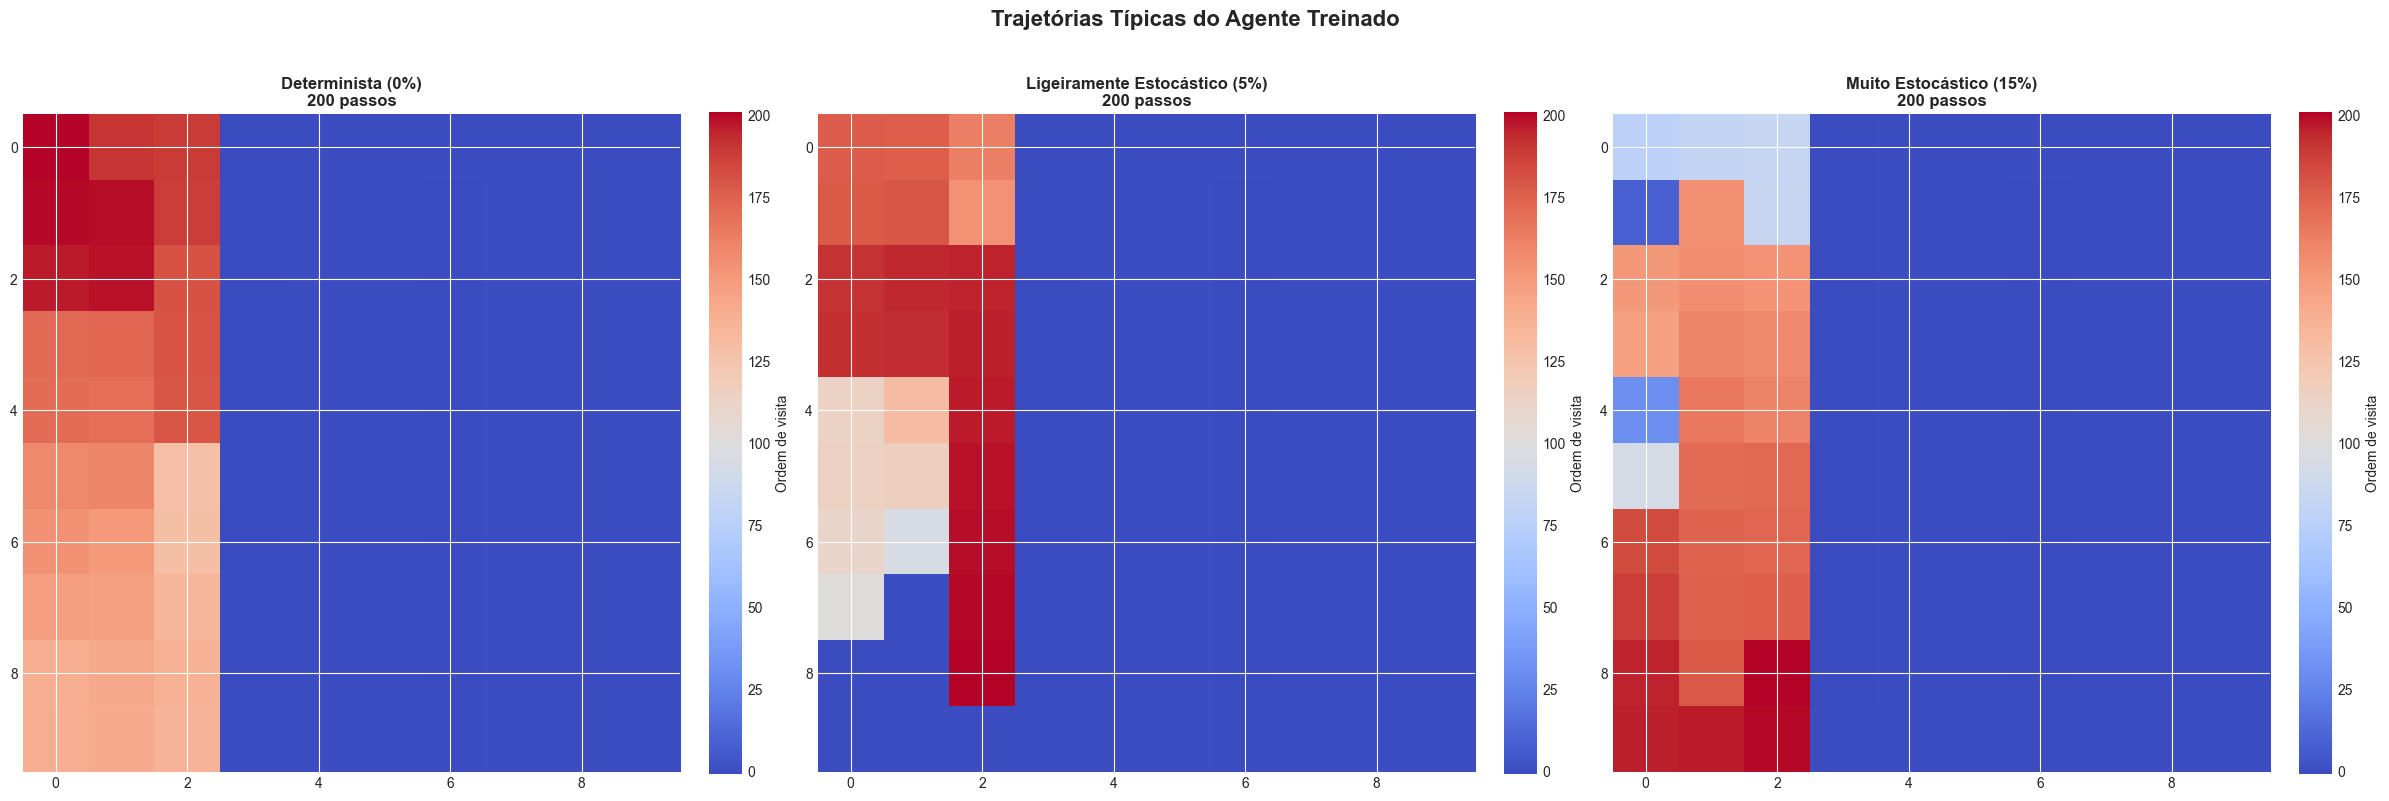

In [13]:
# Visualizar trajetória típica para cada nível de estocasticidade
def get_trajectory(agent, max_steps=200):
    """Obtém trajetória do agente."""
    trajectory = [1]  # Estado inicial
    state = 1
    
    for _ in range(max_steps):
        action = agent.get_best_action(state)
        next_state, _ = agent.env.transition(state, action)
        trajectory.append(next_state)
        
        if next_state == agent.env.goal_state:
            break
        
        state = next_state
    
    return trajectory

# Visualização
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for idx, level_name in enumerate(level_names):
    agent = all_results[level_name]['agents'][10]  # seed=10
    trajectory = get_trajectory(agent)
    
    # Cria grid para visualização
    grid = np.zeros((agent.env.grid_size, agent.env.grid_size))
    
    # Marca paredes
    for wall in agent.env.walls:
        row, col = agent.env.state_to_position(wall)
        grid[row, col] = -1
    
    # Marca trajetória
    for i, state in enumerate(trajectory):
        if state not in agent.env.walls:
            row, col = agent.env.state_to_position(state)
            grid[row, col] = i + 1
    
    im = axes[idx].imshow(grid, cmap='coolwarm', interpolation='nearest')
    axes[idx].set_title(f'{level_name}\n{len(trajectory)-1} passos', 
                       fontsize=12, weight='bold')
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04, label='Ordem de visita')

plt.suptitle('Trajetórias Típicas do Agente Treinado', fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 11. Salvando Resultados

In [ ]:
import pickle
import os

# Preparar dados para salvar (sem os agentes completos - muito grandes)
results_to_save = {}
for level_name in level_names:
    results = all_results[level_name].copy()
    # Remove agentes para economizar espaço
    results.pop('agents', None)
    results_to_save[level_name] = results

save_data = {
    'results': results_to_save,
    'test_performance': test_performance,
    'policy_differences': policy_differences,
    'parameters': {
        'n_experiments': n_experiments,
        'n_training_steps': n_training_steps,
        'test_points': test_points,
        'greed': greed,
        'stochastic_levels': stochastic_levels
    }
}

with open('exercicio5_results.pkl', 'wb') as f:
    pickle.dump(save_data, f)

print("Resultados salvos em 'exercicio5_results.pkl'")
print(f"Tamanho do arquivo: {os.path.getsize('exercicio5_results.pkl') / 1024:.2f} KB")

Resultados salvos em 'exercicio5_results.pkl'


NameError: name 'os' is not defined